#Exploratory Data Analysis (EDA)

##Table of Contents

* I. Introduction
* II. Exploratory Data Analysis (EDA)
* i. Basic Information
* ii. Distributions of Numeric Features
* iii. Distributions of Categorical Features
* III. Final Thoughts

##I. Introduction
The HR department at a company...

##II. Exploratory Data Analysis (EDA)

We know we are interested in full-time (salaried) employees who have left the company. Therefore, our target variable is 'status', of which there are two classes: 'left' and 'employed'. This makes it a binary categorical feature. We can do some exploratory analysis to get familiar with the data and see if there are any insights we can glean that may help us with feature engineering.

In [1]:
#Import libraries

# NumPy for numerical computing
import numpy as np 


# Pandas for DataFrames
import pandas as pd
# Expands the max number of columns Pandas is allowed to display at once
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
#displays visualizations directly in the notebook
%matplotlib inline


# Seaborn for easier visualization
import seaborn as sns
#makes it easier to see visualizations
sns.set_style('darkgrid')


# (Optional) Suppress FutureWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [10]:
# Import the dataset
df = pd.read_csv('employee_data.csv')

##i. Basic Information

In [11]:
# Display column datatypes to check the categorical and numeric features and compare to Data Dictionary. Make sure everything makes sense.
print(df.dtypes)

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object


In [12]:
# Display the df shape and first and last 10 rows to get familair with the data and check for corrupted data
print(df.shape)
print(df.head(10))
print(df.tail(10))


(14249, 10)
   avg_monthly_hrs   department  filed_complaint  last_evaluation  n_projects  \
0              221  engineering              NaN         0.932868           4   
1              232      support              NaN              NaN           3   
2              184        sales              NaN         0.788830           3   
3              206        sales              NaN         0.575688           4   
4              249        sales              NaN         0.845217           3   
5              140        sales              NaN         0.589097           4   
6              121        sales              1.0         0.625399           3   
7              150  engineering              NaN         0.644586           4   
8              215  engineering              1.0         0.524114           3   
9              269      support              NaN         0.909364           5   

   recently_promoted  salary  satisfaction    status  tenure  
0                NaN     low     

Already we can see some changes we need to make to the data to make our EDA run a bit smoother.
First, we know from the Data Dictionary that 'filed_complaint' and 'recently_promoted' should be indicator variables, i.e: 1 should represent someone who filed a complaint or got recently promoted, while 0 should represent someone who did not. Instead, the dataset has np.nan (i.e. missing values) where it should be the value 0.

We can also see that 'salary' is encoded as a categorical feature with three sequential levels ('low', 'medium', 'high'). When a categorical feature's classes have a natural sequence, such as low --> medium --> high, this categorical feature is referred to as an ordinal feature. We can then choose to encode 'salary' as an ordinal feature ('salary_numeric') using sequential numbers (0,1,2).

We should make sure to repeat these again at the data cleaning step.

In [23]:
# Encode salary feature with sequential numbers
df['salary_numeric'] = df.salary.replace({'low': 0, 'medium': 1, 'high': 2})

In [18]:
# Fill missing values for filed_complaint and recently_promoted with 0
df.filed_complaint.fillna(0, inplace=True)
df.recently_promoted.fillna(0, inplace=True)

###ii. Distributions of Numeric Features
We can now start our EDA by plotting the distributions of our numeric features using a Pandas histogram grid. Some questions to consider:1. Are there any distributions that don't make sense?
2. Does it look like there are potential outliers that don't make sense?
3. Are there any boundaries that don't make sense?

Thankfully, nothing appears out of the ordinary with this dataset (although this is often not the case).

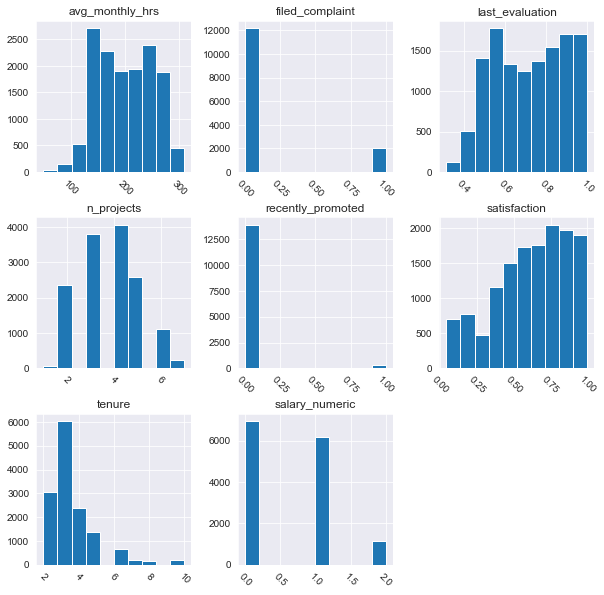

In [24]:
# Plot histogram grid
df.hist(figsize=(10,10), xrot=-45)

# Clear the text "residue"
plt.show()

###iii. Distributions of Categorical Features
Let's first display the summary statistics for our categorical features. Some questions to consider:1. How many unique classes does it have?
2. What is the most frequent class?
3. How many observations belong to the most frequent class?
4. Does it have any missing values?

In [25]:
# Summarize categorical features
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


Let's also display detailed statistics grouped by our target variable ('status') and calculate the average value of each fetaure within each class.

In [38]:
# Group df by status and get the average of each feature
df.groupby('status').mean()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,salary_numeric
status,,,,,,,,
Employed,199.142230,0.174843,0.714479,3.786282,0.026353,0.675979,3.380245,0.648724
Left,207.254232,0.045738,0.730706,3.847936,0.005346,0.447500,3.869023,0.414909


We can see that, on average, 'leavers' worked more hours per month, filed fewer complaints, had higher evaluations, worked more projects, were promoted less often, were less satisfied, were tenured for longer, and had lower salaries. We'll dive deeper into some of these features to see if we can glean additional insights.

First, let's look at our data visually and plot bar plots for each categorical feature.

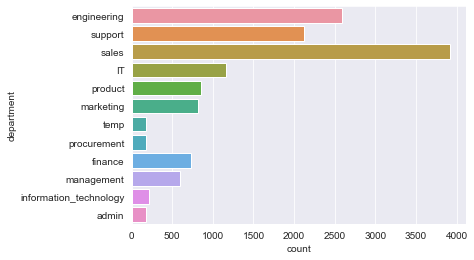

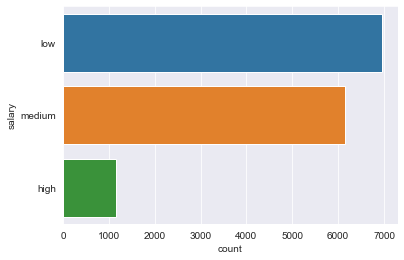

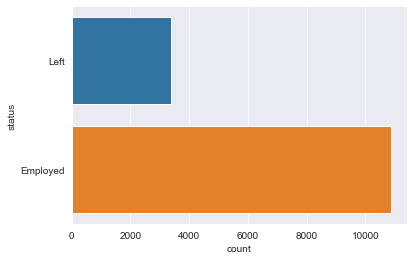

In [26]:
# Create bar plots for each categorical feature
for feature in df.dtypes[df.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df)
    plt.show()

We can from the 'department' plot that there are two issue that need our attention:
1. The dataset contains data on temporary 'temp' employees, but our model only needs to calculate the likelihood that a salaried employee will leave.
2. 'IT' and 'information_technology' are listed as separate classes but they are the same department.  

In [27]:
# Remove temp employees from the dataset
df = df[df.department != 'temp']

In [28]:
# Replace all instances of 'IT' with 'information_technology'
df.department.replace('information_technology', 'IT', inplace=True)

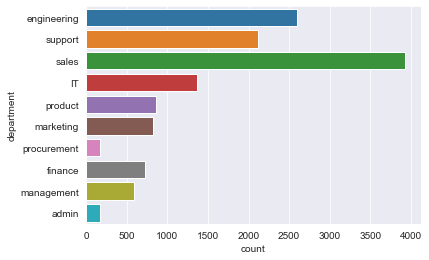

In [32]:
# As a sanity check, display the bar plot for department distributions again
sns.countplot(y='department', data=df)
plt.show()

Let's also visualize the data using a heat map. This will give us a better sense of positive (red) and negative (blue) correlations between different features.

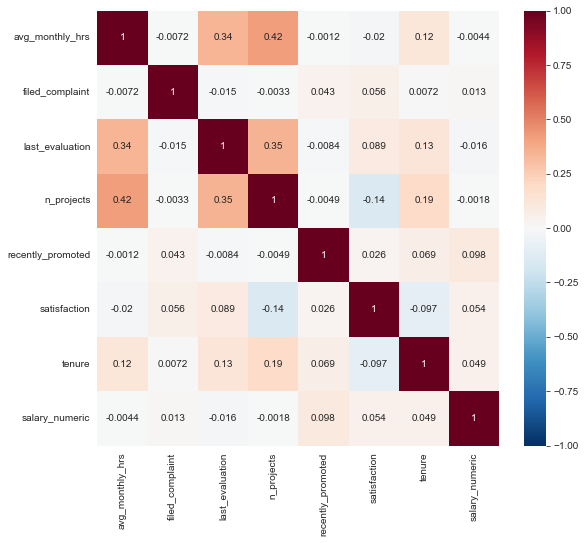

In [33]:
corr = df.corr()

plt.figure(figsize=(9,8))
sns.heatmap(corr,
            annot=True,
            #set color to diverging red-blue
            cmap='RdBu_r',
            vmin=-1,
            vmax=1)
plt.show()


Next we can perform some segmentations, which are a good way to visualize the relationship between numeric and categorical features.
Let's start by doing a univariate segmentation (displaying one variable at a time) between 'satisfaction' and 'status' (our target variable). Violin plots are a better choice here because they can show us the entire probability distribution of the data, compared to a box plot that only shows the summary statistics (median, interquantile range, etc)

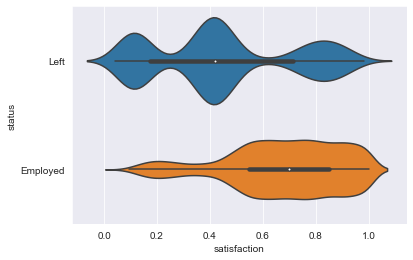

In [3]:
# Violin plot of satisfaction vs. status
sns.violinplot(y='status', x='satisfaction', data=df)
plt.show()

Right away we get some good information: 
1. The majority of current employees are satisfied with their jobs (as one might intuit, but is always good to confirm)
2. There are two groups of employees who are unsatisfied with their jobs who left (as one might intuit).
3. However, there appears to be a third, highly satisfied group of employees who still left. 

Let's also look the relationship between last_evaluation and status:

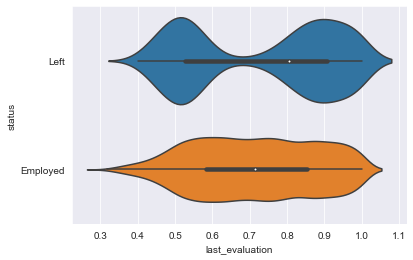

In [37]:
# Violin plot of status vs. last_evaluation
sns.violinplot(y='status', x='last_evaluation', data=df)
plt.show()

Let's dive deeper into these groups to get a better picture. We'll use a bivariate segmentation (displaying two numerical features and one categorical feature) to see if there are potential interactions between multiple features. We can look at 'satisfaction' as well as 'last_evaluation' to see if there is any relationship- we already saw that these features were posiviely correlated on our heat map.

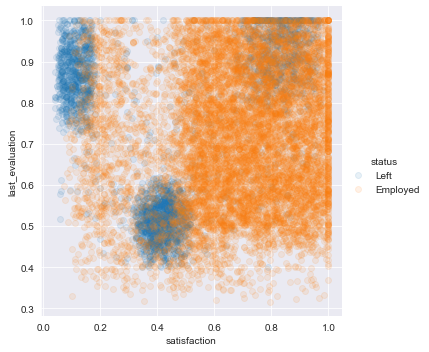

In [4]:
# Scatterplot of satisfaction vs. last_evaluation
sns.lmplot(x='satisfaction',
           y='last_evaluation',
           #color each point based on target variable
           hue='status',
           data=df,
           fit_reg=False,
           #make the points partially transparent to see both classes
           scatter_kws={'alpha':0.1})
plt.show()

This is useful, but we're more interested in the employees that left.

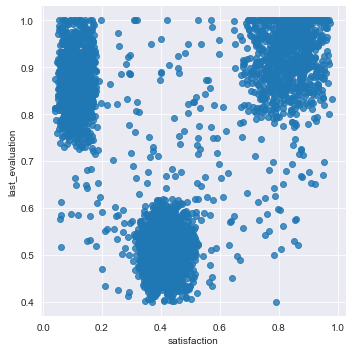

In [5]:
# Scatterplot of satisfaction vs. last_evaluation, only those who have left
sns.lmplot(x='satisfaction',
           y='last_evaluation',
           data=df[df.status == 'Left'],
           fit_reg=False)
plt.show()

We can now definitely see there are three clusters of people who have left. While many machine learning algorithms can learn these automatically, sometimes it's helpful to explicitly highlight these clusters.

Therefore, in the Feature Engineering stage, we'll create three indicator features:
1) "Underperformers: last_evaluation < 0.6
2) "Unhappy": satisfaction < 0.2 and last_evaluation > 0.7
3) "Overachievers":  satisfaction > 0.7 and last_evaluation > 0.8


We can also look at the relationship between 'status' and 'avg_monthly_hrs', as there may be additional 'underperformers' who are working fewer hours than average.

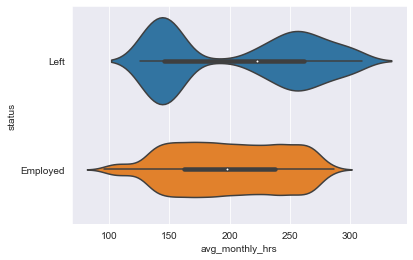

In [35]:
# Violin plot of status vs. avg_montly_hours
sns.violinplot(y='status', x='avg_monthly_hrs', data=df)
plt.show()

Indeed, we can see that employees who left can be divded into two groups: those that worked above and those that worked below the average monthly hours.

Which department worked the greatest number of hours on average? We can see that it's engineering.

In [42]:
df.groupby('department').mean().sort_values(by='avg_monthly_hrs', ascending=False)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,salary_numeric
department,,,,,,,,
engineering,202.469522,0.138889,0.722332,3.872299,0.010031,0.617907,3.402392,0.564815
IT,202.174453,0.140876,0.720017,3.810219,0.005109,0.628079,3.456204,0.572263
admin,201.272727,0.096591,0.726282,3.897727,0.028409,0.611450,3.369318,0.596591
finance,201.175824,0.119505,0.723880,3.815934,0.019231,0.586787,3.543956,0.641484
management,201.025210,0.173109,0.729714,3.857143,0.114286,0.630428,4.294118,1.057143
support,200.975495,0.155042,0.723200,3.804430,0.008483,0.626923,3.394910,0.554194
sales,200.842467,0.141728,0.711254,3.772878,0.024726,0.623075,3.527148,0.556207
product,199.991860,0.151163,0.719616,3.817442,0.000000,0.628774,3.487209,0.577907
marketing,199.664225,0.159951,0.715018,3.687424,0.048840,0.629122,3.567766,0.620269


Let's do another bivariate segmentation for 'last_evaluation' and 'avg_monthly_hrs' segmented by 'leavers'.

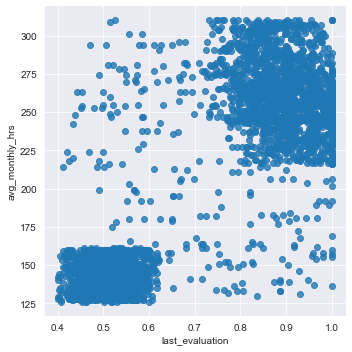

In [47]:
sns.lmplot(x='last_evaluation',
           y='avg_monthly_hrs',
           data=df[df.status == 'Left'],
           fit_reg=False)
plt.show()

These data suggest that we could create two additional indicator features:
1) 'Stars': avg_monthly_hrs > 215 and last_evaluation > 0.75
2) 'Slackers: avg_monthly_hrs < 165 and last_evaluation < 0.65

III. Now that we've done the initial EDA and explored some potential features to engineer and some initial data cleaning steps, we can create our analytical base table (ABT). This is the table that has already been cleaned and augmented through feature engineering, and we'll be performing our analyses or building our models on it.